In [1]:
import matplotlib.pyplot as plt
import pandas as p
import seaborn as sns
import numpy as np
%matplotlib inline
from scipy.stats import linregress
from scipy.spatial import distance
from matplotlib import colors
import scipy
import os
import copy
# from matplotlib.backends.backend_pdf import PdfPages

from ast import literal_eval

sns.set_color_codes()
sns.set_style('white')
sns.set_style('ticks')



In [2]:
nextera_hiseq =  p.read_table('IndexSwappingAnalysis/BB_070418_Hiseq_DualIndex_Diagonal_primercondensedBarcodeCounts.txt',sep='\t')

# nextera =  p.read_table('BB_070418_Hiseq_DualIndex_Diagonal_primercondensedBarcodeCounts.txt',sep='\t')





/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:

barcode_counts = nextera_hiseq
to_counts = []
to_totals = []

for col in barcode_counts.columns:
    totaling = 0
    for i in range(len(barcode_counts.index)):
        bc = barcode_counts[col].values[i]
        if col == 'barcode':
            bc = barcode_counts[col].values[i]
        else:
            n,s,f,r = col.split('_')
#             if col in real_reads.keys():
#                 condition = real_reads[col]
#                 rr = True
#             else:
#                 rr = False
#                 condition = 'NA'
            count = barcode_counts[col].values[i]
            totaling += count

            to_counts.append({'barcode':bc,'N':n,'S':s,'F':f,'R':r,'count':count})
    if col != 'barcode':
        to_totals.append({'N':n,'S':s,'F':f,'R':r,'total':totaling})


nextera_counts = p.DataFrame(to_counts, columns=['barcode','N','S','F','R','count'])
nextera_totals = p.DataFrame(to_totals, columns=['N','S','F','R','total'])



In [4]:
n_primers = np.unique(nextera_totals['N'].values)
s_primers = np.unique(nextera_totals['S'].values)
f_primers = np.unique(nextera_totals['F'].values)
r_primers = np.unique(nextera_totals['R'].values)

In [5]:
fwd_combo_list = []
rev_combo_list = []
for item in range(len(nextera_totals)):
    fwd_combo_list.append(nextera_totals['N'].values[item] + '-' + nextera_totals['R'].values[item])
    rev_combo_list.append(nextera_totals['S'].values[item] + '-' + nextera_totals['F'].values[item])
nextera_totals['fwd_combo'] = fwd_combo_list
nextera_totals['rev_combo'] = rev_combo_list

In [6]:
nextera_totals = nextera_totals.sort_values('total',ascending=False)
real_reads = [True]*8 + [False]*(len(nextera_totals)-8)
nextera_totals['real_read'] = real_reads

In [7]:
real_fwds = nextera_totals[nextera_totals['real_read']==True]['fwd_combo'].values
real_revs = nextera_totals[nextera_totals['real_read']==True]['rev_combo'].values
real_fs = nextera_totals[nextera_totals['real_read']==True]['F'].values
real_ns = nextera_totals[nextera_totals['real_read']==True]['N'].values
real_ss = nextera_totals[nextera_totals['real_read']==True]['S'].values
real_rs = nextera_totals[nextera_totals['real_read']==True]['R'].values


nextera_totals = nextera_totals.sort_values(['total'],ascending=False)

template_swaps = []
single_swaps = []
single_swaps_inline = []
single_swaps_nextera = []
double_swaps = []
for ix in range(len(nextera_totals)):
    print(nextera_totals['real_read'].values[ix],nextera_totals['fwd_combo'].values[ix],nextera_totals['rev_combo'].values[ix])
    if nextera_totals['real_read'].values[ix] == True:
        template_swaps.append(False)
        single_swaps.append(False)
        double_swaps.append(False)
        single_swaps_nextera.append(False)
        single_swaps_inline.append(False)
    elif nextera_totals['fwd_combo'].values[ix] in real_fwds and nextera_totals['rev_combo'].values[ix] in real_revs:
        template_swaps.append(True)
        single_swaps.append(False)
        double_swaps.append(False)
        single_swaps_nextera.append(False)
        single_swaps_inline.append(False)
    else:
        n = nextera_totals['N'].values[ix]
        s = nextera_totals['S'].values[ix]
        f = nextera_totals['F'].values[ix]
        r = nextera_totals['R'].values[ix]
        
        closest = 0
        
        for true in range(8):
            intersection = set([n,s,f,r]).intersection([nextera_totals['N'].values[true],nextera_totals['S'].values[true],nextera_totals['F'].values[true],nextera_totals['R'].values[true]])
            this_sim = len(intersection)
            

            if this_sim > closest:
                closest = this_sim
                same_indices = intersection
                
#         print(sorted(list(chosen)))
        same_indices = ''.join(sorted(list(same_indices)))
        print(same_indices)
#         print(nextera_totals['N'].values[true])
                
        if closest == 3:
            template_swaps.append(False)
            single_swaps.append(True)
            double_swaps.append(False)
            
            if 'N' not in same_indices:
                single_swaps_nextera.append(True)
                single_swaps_inline.append(False)
                
            elif 'S' not in same_indices:
                single_swaps_nextera.append(True)
                single_swaps_inline.append(False)
            
            elif 'F' not in same_indices:
                single_swaps_inline.append(True)
                single_swaps_nextera.append(False)
            else:
                single_swaps_inline.append(True)
                single_swaps_nextera.append(False)
            
        elif closest == 2:
            
            template_swaps.append(False)
            single_swaps.append(False)
            double_swaps.append(True)
            single_swaps_nextera.append(False)
            single_swaps_inline.append(False)
            
        else:
            template_swaps.append(False)
            single_swaps.append(False)
            double_swaps.append(False)
            single_swaps_nextera.append(False)
            single_swaps_inline.append(False)
        
                      
            
nextera_totals['template_swap'] = template_swaps
nextera_totals['single_swap'] = single_swaps  
nextera_totals['double_swap'] = double_swaps
nextera_totals['single_swap_nextera'] = single_swaps_nextera
nextera_totals['single_swap_inline'] = single_swaps_inline



True N723-R305 S518-F207
True N720-R302 S515-F204
True N721-R303 S516-F205
True N722-R304 S517-F206
True N726-R307 S521-F212
True N719-R301 S517-F203
True N727-R308 S522-F210
True N724-R306 S520-F208
False N723-R305 S515-F204
False N720-R302 S518-F207
False N720-R302 S516-F205
False N723-R305 S516-F205
False N719-R301 S515-F204
False N721-R303 S515-F204
False N726-R307 S515-F204
False N721-R303 S518-F207
False N722-R305 S518-F206
R305S518
False N719-R301 S516-F205
False N719-R301 S518-F207
False N727-R308 S515-F204
False N726-R307 S518-F207
False N726-R307 S516-F205
False N720-R302 S517-F203
False N720-R302 S521-F212
False N722-R304 S515-F204
False N720-R303 S516-F204
F204N720
False N722-R304 S518-F207
False N722-R304 S516-F205
False N720-R302 S517-F204
F204N720R302
False N720-R302 S522-F210
False N723-R305 S517-F203
False N723-R305 S521-F212
False N721-R304 S517-F205
F205N721
False N724-R306 S515-F204
False N727-R308 S518-F207
False N720-R302 S517-F206
False N723-R305 S517-F206
False 

False N720-R302 S520-F207
N720R302
False N723-R303 S518-F205
N723S518
False N726-R305 S521-F207
F207R305
False N720-R301 S521-F212
F212S521
False N726-R302 S517-F206
F206S517
False N724-R306 S515-F206
N724R306
False N726-R305 S522-F210
F210S522
False N726-R303 S521-F205
F205R303
False N719-R301 S515-F209
N719R301
False N720-R303 S521-F204
F204N720
False N726-R307 S516-F206
N726R307
False N723-R305 S516-F210
N723R305
False N724-R306 S520-F212
N724R306S520
False N722-R304 S516-F203
N722R304
False N723-R308 S515-F204
F204S515
False N720-R301 S517-F206
F206S517
False N722-R307 S515-F204
F204S515
False N720-R305 S518-F206
R305S518
False N723-R303 S515-F204
F204S515
False N724-R305 S520-F207
F207R305
False N726-R306 S518-F207
F207S518
False N727-R308 S516-F203
N727R308
False N722-R304 S515-F210
N722R304
False N724-R305 S517-F203
F203S517
False N724-R306 S517-F204
N724R306
False N724-R306 S516-F203
N724R306
False N724-R304 S515-F204
F204S515
False N724-R305 S521-F212
F212S521
False N723-R302 

F212N726
False N720-R307 S517-F204
F204N720
False N720-R306 S517-F203
F203S517
False N724-R307 S520-F212
F212R307
False N726-R302 S516-F212
F212N726
False N719-R302 S522-F204
F204R302
False N718-R302 S518-F207
F207S518
False N724-R306 S522-F204
N724R306
False N720-R308 S522-F204
F204N720
False N720-R304 S517-F207
R304S517
False N723-R306 S517-F203
F203S517
False N719-R301 S520-F204
N719R301
False N726-R307 S520-F204
N726R307
False N721-R303 S518-F210
N721R303
False N723-R307 S522-F210
F210S522
False N716-R302 S515-F204
F204R302S515
False N723-R302 S517-F204
F204R302
False N727-R308 S518-F208
N727R308
False N723-R306 S521-F212
F212S521
False N722-R304 S518-F208
N722R304
False N726-R307 S518-F208
N726R307
False N719-R301 S521-F205
N719R301
False N723-R302 S520-F208
F208S520
False N718-R301 S518-F207
F207S518
False N729-R302 S517-F206
F206S517
False N724-R306 S518-F205
N724R306
False N719-R304 S522-F210
F210S522
False N724-R304 S517-F207
R304S517
False N727-R308 S521-F208
N727R308
False N

False N728-R308 S521-F212
F212S521
False N727-R301 S517-F202
R301S517
False N726-R305 S517-F202
R305
False N723-R305 S516-F212
N723R305
False N720-R307 S521-F210
R307S521
False N724-R306 S517-F201
N724R306
False N727-R308 S522-F201
N727R308S522
False N720-R308 S522-F212
R308S522
False N720-R303 S516-F201
R303S516
False N721-R307 S520-F208
F208S520
False N722-R305 S516-F204
R305
False N726-R303 S516-F208
R303S516
False N723-R305 S522-F209
N723R305
False N726-R307 S516-F201
N726R307
False N723-R305 S515-F201
N723R305
False N721-R308 S520-F208
F208S520
False N726-R307 S522-F211
N726R307
False N720-R306 S520-F207
R306S520
False N721-R301 S520-F208
F208S520
False N716-R304 S517-F206
F206R304S517
False N729-R304 S515-F204
F204S515
False N719-R301 S516-F211
N719R301
False N726-R302 S515-F202
R302S515
False N719-R302 S516-F204
F204R302
False N729-R304 S518-F207
F207S518
False N719-R302 S518-F204
F204R302
False N719-R306 S522-F210
F210S522
False N727-R305 S517-F202
R305
False N719-R305 S520-F20

False N721-R301 S515-F203
F203R301
False N723-R303 S516-F208
R303S516
False N722-R304 S513-F202
N722R304
False N720-R302 S520-F211
N720R302
False N728-R303 S521-F212
F212S521
False N719-R302 S515-F211
R302S515
False N723-R308 S515-F207
F207N723
False N716-R301 S522-F210
F210S522
False N719-R305 S516-F201
R305
False N726-R304 S522-F212
F212N726
False N726-R308 S522-F209
R308S522
False N719-R305 S516-F204
R305
False N719-R305 S515-F207
F207R305
False N724-R306 S516-F202
N724R306
False N719-R304 S516-F206
F206R304
False N719-R305 S515-F209
R305
False N719-R303 S516-F201
R303S516
False N727-R302 S515-F201
R302S515
False N720-R307 S520-F212
F212R307
False N727-R307 S513-F210
F210N727
False N722-R304 S520-F202
N722R304
False N721-R302 S521-F205
F205N721
False N719-R305 S516-F202
R305
False N727-R308 S513-F204
N727R308
False N723-R306 S520-F206
R306S520
False N720-R304 S522-F206
F206R304
False N720-R308 S520-F210
F210R308
False N720-R308 S521-F210
F210R308
False N726-R306 S522-F212
F212N726
F

False N728-R308 S518-F206
S518
False N729-R304 S517-F202
R304S517
False N719-R304 S516-F204
F204
False N716-R302 S517-F206
F206S517
False N729-R302 S515-F206
R302S515
False N729-R306 S515-F204
F204S515
False N719-R307 S515-F212
F212R307
False N729-R301 S515-F204
F204S515
False N716-R308 S517-F201
S517
False N728-R302 S515-F210
R302S515
False N728-R301 S515-F211
S515
False N729-R302 S517-F212
R302
False N718-R303 S521-F212
F212S521
False N729-R303 S516-F203
R303S516
False N716-R306 S518-F207
F207S518
False N716-R304 S518-F207
F207S518
False N716-R305 S518-F206
R305S518
False N729-R305 S516-F202
R305
False N719-R301 S513-F210
N719R301
False N716-R301 S520-F201
R301
False N729-R306 S517-F206
F206S517
False N729-R302 S517-F202
R302
False N729-R301 S517-F206
F206S517
False N716-R305 S520-F208
F208S520
False N716-R304 S520-F208
F208S520
False N716-R308 S520-F208
F208S520
False N728-R306 S515-F211
S515
False N718-R304 S522-F210
F210S522
False N718-R306 S522-F210
F210S522
False N722-R305 S520-

R307
False N716-R301 S520-F211
R301
False N716-R308 S521-F202
S521
False N716-R308 S521-F206
F206
False N716-R306 S521-F206
F206
False N718-R305 S516-F201
R305
False N718-R308 S515-F211
S515
False N716-R304 S521-F206
F206R304
False N716-R308 S521-F204
F204
False N716-R307 S520-F206
F206
False N718-R307 S513-F202
R307
False N718-R301 S513-F203
F203R301
False N718-R303 S515-F211
S515
False N718-R304 S515-F211
S515
False N718-R305 S515-F211
R305
False N718-R306 S515-F211
S515
False N718-R307 S515-F211
S515
False N718-R301 S515-F212
S515
False N716-R305 S521-F206
R305
False N718-R302 S515-F212
R302S515
False N718-R303 S515-F212
S515
False N718-R304 S515-F212
S515
False N718-R305 S515-F212
R305
False N718-R306 S515-F212
S515
False N718-R307 S515-F212
F212R307
False N718-R308 S515-F212
S515
False N718-R301 S516-F201
S516
False N718-R302 S516-F201
R302
False N718-R304 S516-F201
S516
False N716-R303 S521-F206
R303
False N716-R302 S521-F206
R302
False N716-R301 S521-F206
F206
False N716-R308 S5

R307
False N716-R308 S522-F211
R308S522
False N716-R301 S522-F212
F212
False N716-R302 S522-F212
R302
False N716-R303 S522-F212
R303
False N716-R304 S522-F212
R304
False N716-R305 S522-F212
R305
False N716-R306 S522-F212
F212
False N716-R307 S522-F212
F212R307
False N716-R308 S522-F212
R308S522
False N718-R301 S513-F201
R301
False N716-R304 S522-F208
R304
False N716-R305 S522-F208
R305
False N722-R308 S521-F201
N722
False N716-R302 S521-F202
R302
False N716-R306 S520-F212
R306S520
False N716-R307 S520-F212
F212R307
False N716-R308 S520-F212
F212
False N716-R301 S521-F201
S521
False N716-R303 S521-F201
R303
False N716-R304 S521-F201
R304
False N716-R305 S521-F201
R305
False N716-R306 S521-F201
S521
False N716-R308 S521-F201
S521
False N716-R301 S521-F202
S521
False N716-R303 S521-F202
R303
False N716-R307 S522-F208
R307
False N716-R304 S521-F202
R304
False N716-R305 S521-F202
R305
False N716-R306 S521-F202
S521
False N716-R303 S520-F211
R303
False N716-R307 S521-F202
R307S521
False N716

False N719-R307 S518-F208
S518
False N719-R308 S518-F208
S518
False N719-R302 S522-F201
R302
False N719-R303 S522-F201
R303
False N719-R304 S522-F201
R304
False N719-R305 S522-F201
R305
False N719-R306 S522-F201
N719
False N719-R307 S522-F201
R307
False N719-R308 S522-F201
R308S522
False N719-R302 S522-F202
R302
False N719-R303 S522-F202
R303
False N719-R304 S522-F202
R304
False N719-R305 S522-F202
R305
False N719-R306 S522-F202
N719
False N719-R307 S522-F202
R307
False N719-R308 S522-F202
R308S522
False N719-R305 S522-F203
F203N719
False N719-R303 S522-F204
F204
False N719-R304 S522-F204
F204
False N719-R304 S521-F209
R304
False N719-R305 S521-F209
R305
False N719-R306 S521-F209
S521
False N720-R301 S513-F202
N720
False N720-R305 S513-F202
R305
False N720-R306 S513-F202
N720
False N720-R307 S513-F202
N720
False N720-R308 S513-F202
N720
False N720-R301 S513-F203
F203R301
False N720-R303 S513-F203
N720
False N720-R304 S513-F203
N720
False N720-R305 S513-F203
R305
False N720-R306 S513-F2

False N720-R303 S518-F202
S518
False N720-R301 S518-F202
S518
False N720-R308 S518-F201
S518
False N720-R307 S518-F201
S518
False N720-R306 S516-F207
F207
False N720-R307 S516-F207
F207
False N720-R308 S516-F207
F207
False N720-R301 S516-F208
N720
False N720-R304 S516-F208
N720
False N720-R305 S516-F208
R305
False N720-R307 S516-F208
N720
False N720-R308 S516-F208
N720
False N720-R301 S516-F209
N720
False N720-R303 S516-F209
R303S516
False N720-R304 S516-F209
N720
False N720-R305 S516-F209
R305
False N720-R306 S516-F209
N720
False N720-R307 S516-F209
N720
False N720-R308 S516-F209
N720
False N720-R301 S516-F210
N720
False N720-R308 S516-F210
F210R308
False N720-R307 S517-F207
F207
False N720-R308 S517-F207
F207
False N720-R301 S517-F208
R301S517
False N720-R306 S518-F201
S518
False N720-R303 S518-F201
S518
False N720-R305 S517-F208
R305
False N720-R306 S513-F211
N720
False N720-R307 S513-F209
N720
False N720-R301 S518-F208
S518
False N720-R304 S516-F203
N720
False N720-R307 S516-F202
N

False N721-R301 S516-F207
N721S516
False N721-R306 S516-F207
N721S516
False N721-R307 S516-F207
N721S516
False N721-R308 S516-F207
N721S516
False N721-R301 S516-F208
N721S516
False N721-R305 S516-F208
N721S516
False N721-R307 S516-F208
N721S516
False N721-R308 S516-F208
N721S516
False N721-R306 S517-F207
F207
False N721-R302 S517-F207
F207
False N721-R301 S517-F207
R301S517
False N721-R308 S517-F204
F204
False N721-R304 S516-F211
N721S516
False N721-R306 S516-F211
N721S516
False N721-R307 S516-F211
N721S516
False N721-R308 S516-F211
N721S516
False N721-R301 S516-F212
N721S516
False N721-R302 S516-F212
N721S516
False N721-R304 S516-F212
N721S516
False N721-R305 S516-F212
N721S516
False N721-R306 S516-F212
N721S516
False N721-R308 S516-F212
N721S516
False N721-R302 S517-F201
R302
False N721-R305 S517-F201
R305
False N721-R306 S517-F201
N721
False N721-R307 S517-F201
N721
False N721-R308 S517-F201
N721
False N721-R302 S517-F202
R302
False N721-R306 S517-F202
N721
False N721-R307 S517-F202

False N722-R302 S513-F206
F206N722
False N722-R303 S513-F206
F206N722
False N722-R306 S513-F206
F206N722
False N722-R303 S513-F208
R303
False N722-R307 S513-F206
F206N722
False N722-R308 S513-F206
F206N722
False N722-R301 S513-F207
F207
False N722-R302 S513-F207
F207
False N722-R303 S513-F207
F207
False N722-R305 S513-F207
F207R305
False N722-R306 S513-F207
F207
False N722-R307 S513-F207
F207
False N722-R308 S513-F207
F207
False N722-R301 S513-F208
N722
False N722-R306 S513-F212
N722
False N722-R305 S513-F212
R305
False N722-R304 S513-F212
N722R304
False N722-R303 S513-F212
R303
False N722-R306 S518-F205
S518
False N722-R303 S516-F202
R303S516
False N722-R301 S516-F202
S516
False N722-R308 S513-F209
N722
False N722-R301 S513-F210
N722
False N722-R302 S513-F210
R302
False N722-R303 S513-F210
R303
False N722-R304 S513-F210
N722R304
False N722-R305 S513-F210
R305
False N722-R306 S513-F210
N722
False N722-R307 S513-F210
N722
False N722-R308 S513-F210
F210R308
False N722-R301 S513-F211
N722

False N723-R304 S515-F202
N723
False N723-R303 S518-F204
N723S518
False N723-R307 S518-F204
N723S518
False N723-R308 S518-F204
N723S518
False N723-R303 S522-F201
N723
False N723-R304 S522-F201
N723
False N723-R305 S522-F201
N723R305
False N723-R306 S522-F201
N723
False N723-R307 S522-F201
N723
False N723-R308 S522-F201
R308S522
False N723-R301 S522-F202
N723
False N723-R302 S522-F202
N723
False N723-R303 S522-F202
N723
False N723-R304 S522-F202
N723
False N723-R306 S522-F202
N723
False N723-R307 S522-F202
N723
False N723-R308 S522-F202
R308S522
False N723-R302 S522-F203
N723
False N723-R304 S522-F203
N723
False N723-R306 S522-F203
N723
False N723-R308 S515-F206
N723
False N723-R304 S515-F206
F206R304
False N723-R306 S518-F202
N723S518
False N723-R302 S517-F210
N723
False N723-R306 S517-F208
F208R306
False N723-R307 S517-F208
N723
False N723-R308 S517-F208
N723
False N723-R301 S517-F209
R301S517
False N723-R302 S517-F209
N723
False N723-R303 S517-F209
N723
False N723-R304 S517-F209
R304

False N724-R303 S513-F210
R303
False N724-R306 S513-F211
N724R306
False N724-R305 S513-F211
R305
False N724-R304 S513-F211
R304
False N729-R304 S522-F208
R304
False N724-R301 S513-F206
F206
False N724-R302 S513-F206
R302
False N724-R303 S513-F206
R303
False N724-R304 S513-F206
F206R304
False N724-R305 S513-F206
R305
False N724-R306 S513-F206
N724R306
False N724-R307 S513-F206
F206
False N724-R307 S513-F205
F205
False N729-R304 S522-F201
R304
False N724-R302 S513-F209
R302
False N724-R304 S513-F209
R304
False N729-R304 S522-F209
R304
False N729-R303 S522-F209
R303
False N729-R301 S522-F209
R301
False N729-R308 S522-F208
R308S522
False N729-R307 S522-F208
R307
False N729-R306 S522-F208
F208R306
False N724-R301 S513-F211
R301
False N724-R302 S513-F211
R302
False N729-R305 S522-F209
R305
False N724-R303 S513-F211
R303
False N724-R301 S515-F205
S515
False N729-R306 S522-F204
F204
False N729-R307 S522-F204
F204
False N729-R307 S522-F206
F206
False N729-R302 S517-F211
R302
False N729-R301 S51

F204
False N727-R303 S513-F204
F204
False N728-R302 S513-F206
R302
False N727-R304 S513-F204
F204
False N728-R301 S513-F206
F206
False N728-R308 S513-F205
F205
False N727-R305 S513-F204
R305
False N728-R307 S513-F205
F205
False N728-R306 S513-F205
F205
False N727-R302 S513-F204
F204R302
False N728-R305 S513-F205
R305
False N727-R304 S513-F203
R304
False N727-R302 S513-F203
R302
False N728-R306 S513-F204
F204
False N728-R305 S513-F204
R305
False N727-R306 S513-F207
F207
False N727-R308 S513-F205
N727R308
False N727-R303 S513-F206
R303
False N727-R304 S513-F206
F206R304
False N727-R305 S513-F206
R305
False N727-R306 S513-F206
F206
False N727-R307 S513-F206
F206
False N728-R302 S513-F205
R302
False N727-R308 S513-F206
N727R308
False N727-R301 S513-F206
F206
False N728-R307 S521-F210
R307S521
False N728-R308 S521-F206
F206
False N728-R308 S521-F210
F210R308
False N729-R306 S518-F210
S518
False N729-R305 S518-F210
R305S518
False N729-R304 S518-F210
S518
False N729-R303 S518-F210
S518
False 

R307S521
False N729-R308 S515-F212
S515
False N729-R306 S516-F201
S516
False N724-R303 S521-F204
F204
False N724-R304 S521-F204
F204
False N724-R305 S521-F204
R305
False N729-R305 S516-F201
R305
False N729-R304 S516-F201
S516
False N729-R303 S516-F201
R303S516
False N729-R307 S515-F212
F212R307
False N724-R308 S521-F204
F204
False N726-R308 S515-F205
S515
False N724-R302 S521-F205
R302
False N729-R302 S516-F201
R302
False N724-R304 S521-F205
F205
False N728-R305 S522-F202
R305
False N724-R308 S522-F201
R308S522
False N724-R307 S522-F201
R307
False N729-R301 S515-F207
F207
False N724-R302 S520-F209
N724S520
False N729-R306 S516-F208
F208R306
False N724-R301 S520-F210
N724S520
False N724-R302 S520-F210
N724S520
False N724-R303 S520-F210
N724S520
False N729-R303 S516-F208
R303S516
False N729-R302 S516-F208
R302
False N728-R304 S521-F212
F212S521
False N729-R301 S516-F208
S516
False N729-R308 S516-F207
F207
False N729-R304 S516-F208
S516
False N724-R301 S520-F209
N724S520
False N728-R307 S

False N729-R303 S513-F206
R303
False N726-R305 S513-F212
F212N726
False N729-R302 S513-F206
R302
False N728-R301 S522-F207
F207
False N724-R305 S522-F212
R305
False N729-R301 S513-F207
F207
False N728-R307 S522-F206
F206
False N726-R306 S515-F201
S515
False N729-R302 S513-F212
R302
False N726-R305 S515-F201
R305
False N724-R302 S522-F211
R302
False N726-R304 S515-F201
S515
False N724-R303 S522-F211
R303
False N729-R307 S513-F207
F207
False N729-R306 S513-F207
F207
False N724-R304 S522-F211
R304
False N726-R303 S515-F201
S515
False N728-R305 S522-F206
R305
False N729-R305 S513-F207
F207R305
False N724-R304 S522-F212
R304
False N726-R308 S513-F212
F212N726
False N728-R308 S522-F206
R308S522
False N729-R307 S513-F206
F206
False N729-R307 S513-F210
R307
False N728-R306 S522-F205
F205
False N728-R307 S522-F205
F205
False N729-R302 S513-F210
R302
False N726-R305 S515-F202
R305
False N729-R306 S513-F210
F210
False N726-R303 S515-F202
S515
False N724-R303 S520-F204
N724S520
False N728-R301 S52

False N726-R307 S520-F209
N726R307
False N728-R302 S516-F210
R302
False N728-R303 S516-F210
R303S516
False N728-R304 S515-F212
S515
False N728-R303 S515-F212
S515
False N726-R308 S521-F204
N726S521
False N728-R302 S515-F212
R302S515
False N726-R302 S521-F205
N726S521
False N726-R305 S521-F204
N726S521
False N728-R301 S518-F205
S518
False N726-R303 S520-F212
F212N726
False N728-R307 S516-F205
F205S516
False N728-R301 S516-F211
S516
False N728-R308 S516-F210
F210R308
False N728-R307 S516-F210
S516
False N728-R306 S516-F210
S516
False N726-R301 S520-F209
N726
False N726-R302 S520-F209
R302
False N726-R303 S520-F209
R303
False N728-R305 S516-F210
R305
False N728-R304 S516-F211
S516
False N726-R304 S520-F209
R304
False N726-R305 S520-F209
R305
False N726-R306 S520-F209
R306S520
False N728-R307 S516-F204
F204
False N728-R308 S516-F204
F204
False N726-R305 S520-F212
F212N726
False N728-R301 S517-F211
R301S517
False N726-R306 S518-F206
S518
False N728-R308 S517-F201
S517
False N726-R301 S518-F

False N718-R308 S517-F209
S517
False N718-R302 S517-F210
R302
False N718-R303 S517-F210
R303
False N718-R302 S518-F203
S518
False N718-R301 S518-F203
F203R301
False N718-R308 S518-F202
S518
False N718-R307 S518-F202
S518
False N718-R306 S517-F202
S517
False N718-R307 S517-F202
S517
False N718-R306 S517-F203
F203S517
False N718-R307 S517-F203
F203S517
False N718-R301 S517-F204
R301S517
False N718-R303 S517-F204
F204
False N718-R307 S517-F208
S517
False N718-R308 S517-F208
S517
False N718-R301 S517-F209
R301S517
False N718-R301 S518-F201
S518
False N718-R302 S518-F201
S518
False N718-R303 S518-F201
S518
False N718-R304 S518-F201
S518
False N718-R305 S518-F201
R305S518
False N718-R306 S518-F201
S518
False N718-R307 S518-F201
S518
False N718-R308 S518-F201
S518
False N718-R301 S518-F202
S518
False N718-R303 S518-F202
S518
False N718-R304 S518-F202
S518
False N718-R306 S518-F202
S518
False N718-R304 S517-F210
R304S517
False N718-R305 S517-F210
R305
False N718-R306 S517-F210
S517
False N718-

False N727-R301 S518-F203
F203R301
False N727-R306 S518-F201
S518
False N727-R306 S517-F212
S517
False N727-R305 S517-F212
R305
False N727-R307 S518-F201
S518
False N727-R301 S518-F210
F210N727
False N727-R308 S518-F209
N727R308
False N727-R307 S518-F209
S518
False N727-R306 S518-F209
S518
False N727-R304 S518-F209
S518
False N727-R306 S518-F210
F210N727
False N727-R301 S518-F212
S518
False N727-R302 S517-F208
R302
False N727-R301 S518-F204
S518
False N727-R303 S517-F211
R303
False N727-R304 S518-F202
S518
False N727-R305 S517-F211
R305
False N727-R306 S517-F211
S517
False N727-R303 S518-F202
S518
False N727-R307 S517-F211
S517
False N727-R302 S518-F202
S518
False N727-R301 S517-F212
R301S517
False N727-R302 S517-F211
R302
False N727-R302 S517-F212
R302
False N727-R301 S518-F202
S518
False N727-R308 S518-F201
N727R308
False N727-R303 S517-F210
F210N727
False N727-R305 S517-F210
F210N727
False N727-R304 S517-F209
R304S517
False N727-R301 S520-F209
R301
False N727-R304 S516-F210
F210N727

False N726-R301 S518-F202
S518
False N726-R302 S518-F202
S518
False N726-R303 S518-F202
S518
False N726-R304 S518-F202
S518
False N726-R306 S518-F202
S518
False N726-R304 S518-F203
S518
False N726-R306 S518-F201
S518
False N728-R303 S518-F210
S518
False N728-R307 S518-F211
S518
False N728-R302 S518-F212
S518
False N726-R305 S517-F210
R305
False N728-R304 S520-F201
R304
False N726-R306 S517-F210
S517
False N728-R303 S520-F201
R303
False N728-R302 S520-F201
R302
False N728-R301 S520-F201
R301
False N726-R303 S518-F201
S518
False N728-R301 S518-F211
S518
False N726-R302 S518-F201
S518
False N726-R301 S518-F201
S518
False N728-R303 S521-F208
R303
False N726-R304 S516-F202
S516
False N728-R302 S521-F208
R302
False N728-R301 S521-F208
S521
False N726-R306 S516-F202
S516
False N726-R308 S516-F203
S516
False N728-R308 S521-F207
F207
False N728-R306 S521-F207
F207
False N726-R302 S516-F203
R302
False N728-R305 S521-F207
F207R305
False N726-R304 S516-F203
S516
False N728-R304 S521-F207
F207
Fals

In [8]:
nextera_totals = nextera_totals.sort_values('total',ascending=False)
nextera_totals['total_rank'] = range(len(nextera_totals))

Text(0.5, 0, 'Rank')

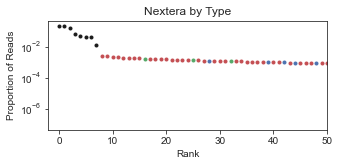

In [9]:
plt.figure(figsize=(5,2))
plt.title('Nextera by Type')
sorted_totals = nextera_totals.sort_values('total',ascending=False)['total'].values
grand_total = np.sum(sorted_totals)

reals = nextera_totals[nextera_totals['real_read'] == True]
plt.plot(reals['total_rank'].values,reals['total'].values/grand_total,'k.')


templates = nextera_totals[nextera_totals['template_swap'] == True]
plt.plot(templates['total_rank'].values,templates['total'].values/grand_total,'r.')

# singles = nextera_totals[nextera_totals['single_swap'] == True]
# plt.plot(singles['total_rank'].values,singles['total'].values/grand_total,'b.')
singles_inline = nextera_totals[nextera_totals['single_swap_inline'] == True]
plt.plot(singles_inline['total_rank'].values,singles_inline['total'].values/grand_total,'m.')

singles_nextera = nextera_totals[nextera_totals['single_swap_nextera'] == True]
plt.plot(singles_nextera['total_rank'].values,singles_nextera['total'].values/grand_total,'b.')

doubles = nextera_totals[nextera_totals['double_swap'] == True]
plt.plot(doubles['total_rank'].values,doubles['total'].values/grand_total,'g.')

others = nextera_totals[(nextera_totals['real_read'] == False) & (nextera_totals['template_swap'] == False) & (nextera_totals['single_swap'] == False)& (nextera_totals['double_swap'] == False)]
plt.plot(others['total_rank'].values,others['total'].values/grand_total,'k.',alpha=0.5)

plt.yscale('log')

plt.xlim(-5,500)
# plt.xlim(-5,2000)

plt.xlim(-2,50)

plt.ylabel('Proportion of Reads')
plt.xlabel('Rank')



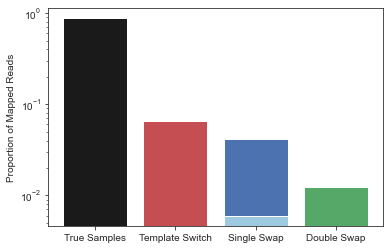

In [10]:
plt.bar([0,1,2,3],[sum(reals['total'])/sum(nextera_totals['total']),
             sum(templates['total'])/sum(nextera_totals['total']),
             (sum(singles_inline['total'])+sum(singles_nextera['total']))/sum(nextera_totals['total']),
             sum(doubles['total'])/sum(nextera_totals['total'])
            ],color=['k','r','b','g'])
plt.bar([2],[
             (sum(singles_inline['total']))/sum(nextera_totals['total']),
            ],color=['#9ecae1'])
plt.yscale('log')
plt.xticks([0,1,2,3],['True Samples','Template Switch','Single Swap','Double Swap'])
plt.ylabel('Proportion of Mapped Reads')

plt.savefig('Figure3_swapping_mechanism_barchart.pdf',bbox_inches='tight')

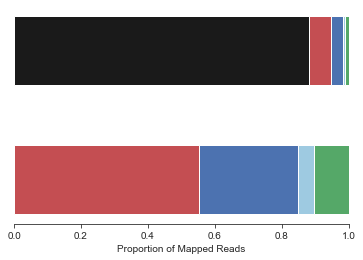

In [11]:
plot_order = [sum(reals['total'])/sum(nextera_totals['total']),
             sum(templates['total'])/sum(nextera_totals['total']),
             sum(singles_nextera['total'])/sum(nextera_totals['total']),
             sum(singles_inline['total'])/sum(nextera_totals['total']),
             sum(doubles['total'])/sum(nextera_totals['total'])]
plot_colors = ['k','r','b','#9ecae1','g']
for p,prop in enumerate(plot_order):
    plt.barh([0],[prop],left=sum(plot_order[:p]),color=plot_colors[p])

    
plot_order = [
             sum(templates['total'])/(sum(nextera_totals['total'])-sum(reals['total'])),
             sum(singles_nextera['total'])/(sum(nextera_totals['total'])-sum(reals['total'])),
             sum(singles_inline['total'])/(sum(nextera_totals['total'])-sum(reals['total'])),
             sum(doubles['total'])/(sum(nextera_totals['total'])-sum(reals['total']))] 

plot_colors = ['r','b','#9ecae1','g']

for pr,prop in enumerate(plot_order):
    plt.barh([1.5],[prop],left=sum(plot_order[:pr]),color=plot_colors[pr])



# plt.axline((0.5, 0.0), (1.0,sum(templates['total'])/(sum(nextera_totals['total'])-sum(reals['total']))),color='k')
# plt.an((1.0, 1.4), (1.0, 1.5),color='k')

# plt.gca().annotate('', xy=(1.0, 0.4), xytext=(1.0, 1.5-0.4),
#             arrowprops=dict(arrowstyle="-",color='k',lw=2))

# plt.gca().annotate('', xy=(sum(reals['total'])/sum(nextera_totals['total']), 0.4), xytext=(0.0, 1.5-0.4),
#             arrowprops=dict(arrowstyle="-",color='k',lw=2))

# plt.bar([2],[
#              (sum(singles_inline['total']))/sum(nextera_totals['total']),
#             ],color=['#9ecae1'])
# plt.yscale('log')
# plt.xticks([0,1,2,3],['True Samples','Template Swap','Single Swap','Double Swap'])
plt.gca().invert_yaxis()
plt.tick_params(labelleft=False, left=False)

plt.xlim(0,1)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xlabel('Proportion of Mapped Reads')

plt.savefig('Figure3_swapping_mechanism_barchart_sideways.pdf',bbox_inches='tight')

In [12]:


singles = sum(singles_inline['total'])+sum(singles_nextera['total'])

print('real',sum(reals['total']),sum(reals['total'])/sum(nextera_totals['total']))
print('template',sum(templates['total']),sum(templates['total'])/sum(nextera_totals['total']))
print('single',singles,(singles)/sum(nextera_totals['total']))
print('single inline',sum(singles_inline['total']),sum(singles_inline['total'])/sum(nextera_totals['total']))
print('single nextera',sum(singles_nextera['total']),sum(singles_nextera['total'])/sum(nextera_totals['total']))
print('double',sum(doubles['total']),sum(doubles['total'])/sum(nextera_totals['total']))



real 9235817 0.8801737319734018
template 695341 0.06626602529739568
single 431527 0.04112454047511835
single inline 62445 0.005951011014302153
single nextera 369082 0.0351735294608162
double 129799 0.012369849926261594


In [13]:
len(templates)

56

In [14]:
reals

,N,S,F,R,total,fwd_combo,rev_combo,real_read,template_swap,single_swap,double_swap,single_swap_nextera,single_swap_inline,total_rank
0,N723,S518,F207,R305,2443813,N723-R305,S518-F207,True,False,False,False,False,False,0
3,N720,S515,F204,R302,2436418,N720-R302,S515-F204,True,False,False,False,False,False,1
31,N721,S516,F205,R303,1903149,N721-R303,S516-F205,True,False,False,False,False,False,2
1,N722,S517,F206,R304,766175,N722-R304,S517-F206,True,False,False,False,False,False,3
2,N726,S521,F212,R307,524067,N726-R307,S521-F212,True,False,False,False,False,False,4
5,N719,S517,F203,R301,513660,N719-R301,S517-F203,True,False,False,False,False,False,5
4,N727,S522,F210,R308,499416,N727-R308,S522-F210,True,False,False,False,False,False,6
5967,N724,S520,F208,R306,149119,N724-R306,S520-F208,True,False,False,False,False,False,7


In [15]:
doubles

,N,S,F,R,total,fwd_combo,rev_combo,real_read,template_swap,single_swap,double_swap,single_swap_nextera,single_swap_inline,total_rank
4369,N722,S518,F206,R305,19427,N722-R305,S518-F206,False,False,False,True,False,False,16
93,N720,S516,F204,R303,15742,N720-R303,S516-F204,False,False,False,True,False,False,25
7,N721,S517,F205,R304,13236,N721-R304,S517-F205,False,False,False,True,False,False,32
15,N723,S517,F207,R304,8830,N723-R304,S517-F207,False,False,False,True,False,False,55
59,N719,S515,F203,R302,6664,N719-R302,S515-F203,False,False,False,True,False,False,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,N721,S516,F211,R307,0,N721-R307,S516-F211,False,False,False,True,False,False,9210
3473,N721,S516,F211,R306,0,N721-R306,S516-F211,False,False,False,True,False,False,9211
3471,N721,S516,F211,R304,0,N721-R304,S516-F211,False,False,False,True,False,False,9212
3528,N721,S517,F207,R301,0,N721-R301,S517-F207,False,False,False,True,False,False,9214


In [17]:
nextera_totals[(nextera_total['N'] in ['N723','N720']) or 
               (nextera_total['S'] in ['S518','S515']) or
               (nextera_total['F'] in ['N723','N720']) or
               (nextera_total['R'] in ['N723','N720'])]

NameError: name 'nextera_total' is not defined

In [ ]:
templates

In [16]:
## rate of template swaps.

alpha_ests = []

for f,r,count in zip(templates['fwd_combo'].values,templates['rev_combo'].values,templates['total'].values):
    
    
    f_total = reals[reals['fwd_combo']==f]['total'].values[0]
    r_total = reals[reals['rev_combo']==r]['total'].values[0]
    
    this_alpha = count/(f_total*r_total)
    
    alpha_ests.append(this_alpha)

## rate of single swaps.

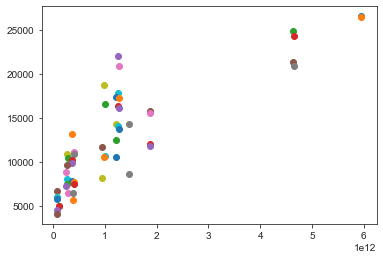

In [17]:
plt.figure()
for f,r,count in zip(templates['fwd_combo'].values,templates['rev_combo'].values,templates['total'].values):
    
    
    f_total = reals[reals['fwd_combo']==f]['total'].values[0]
    r_total = reals[reals['rev_combo']==r]['total'].values[0]
    
    
    plt.scatter(f_total*r_total,count)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

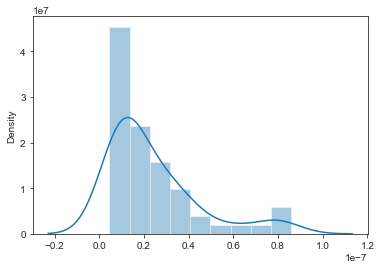

In [18]:
sns.distplot(alpha_ests)

In [19]:
np.mean(alpha_ests)

2.3694196657566513e-08

In [20]:
alpha_ests

[4.456555525298789e-09,
 4.450845222383389e-09,
 5.356634724252278e-09,
 5.227330088882403e-09,
 1.764456105056665e-08,
 4.59189413595215e-09,
 1.6393516164725613e-08,
 4.481244394228654e-09,
 1.915767767996635e-08,
 1.41768152229723e-08,
 1.429832206667639e-08,
 1.3518158830508987e-08,
 1.657446509300972e-08,
 1.304924040018132e-08,
 1.265931565481678e-08,
 8.44314004020522e-09,
 8.286742104657663e-09,
 9.824124611612794e-09,
 1.1724328233314484e-08,
 1.1236456435155332e-08,
 1.0762681298430998e-08,
 3.6213632725226656e-08,
 1.0233684311428712e-08,
 6.480877368593537e-09,
 6.337894338487528e-09,
 1.2279277837391377e-08,
 2.8237587514176807e-08,
 2.7688742116618796e-08,
 4.036520289604787e-08,
 1.0734149373042288e-08,
 8.658893178797328e-09,
 1.0807393458396223e-08,
 3.6843408459510416e-08,
 2.792664865298249e-08,
 2.734532500761016e-08,
 3.5989148321085196e-08,
 3.457295138983439e-08,
 5.926021694167271e-09,
 8.589497409344803e-09,
 3.065784715058906e-08,
 2.1650904772725935e-08,
 1.9

In [21]:
import pandas as p

In [22]:
bb_080618_NS = p.read_table('data/080618_Nextseq_allBarcodeCounts.tab',sep='\t')
bb_082818_HS = p.read_table('data/082818_Hiseq_allBarcodeCounts.tab',sep='\t')

# BB_080618 sample order
condition_order = ['A_0','GG_0','J_1','A0_nodig','I_2','D_3','BB_3','K_4',
'D_0','A_1','K_1','D0_nodig','J_2','E_3','CC_3','L_4',
'E_0','D_1','L_1','E0_nodig','K_2','F_3','DD_3','O_4',
'F_0','E_1','O_1','F0_nodig','L_2','G_3','GG_3','P_4',
'I_0','G_0','P_1','DD_1','O_2','H_3','A_4','AA_4',
'L_0','H_0','AA_1','GG_1','P_2','I_3','D_4','BB_4',
'O_0','J_0','BB_1','A_2','AA_2','J_3','E_4','CC_4',
'P_0','K_0','CC_1','D_2','BB_2','K_3','F_4','DD_4',
'AA_0','F_1','G0_nodig','E_2','CC_2','L_3','G_4','GG_4',
'BB_0','G_1','H0_nodig','F_2','DD_2','O_3','H_4','B3-D1',
'CC_0','H_1','J0_nodig','G_2','GG_2','P_3','I_4','C1-D1',
'DD_0','I_1','K0_nodig','H_2','A_3','AA_3','J_4','Y1-D1']


digest_swaps = ['A_0','A0_nodig','D_0','D0_nodig','E_0','E0_nodig','F_0','F0_nodig']

excluded = ['L_2']

f_list = ['F' + str(f) for f in range(201,213)] # inline forward primers
r_list = ['R' + str(r) for r in range(301,309)] # inline reverse primers 
n_list = ['N' + str(n) for n in [716,718,719,720,721,722,723,724,726,727,728,729]] # nextera n primers
s_list = ['S' + str(s) for s in [513,515,516,517,518,520,521,522]] # nextera s primers

real_reads = {}
counter = 0
for n in range(len(n_list)):
    for s in range(len(s_list)):
        # remove excluded conditions (those that didn't make it into library)
        if condition_order[counter] not in excluded:
            
            # correcting for swapped F primers
            if n_list[n] == 'N726':
                real_reads[n_list[n]+'_'+s_list[s]+'_'+'F212'+'_'+r_list[s]] = condition_order[counter] 
            elif n_list[n] == 'N729':
                real_reads[n_list[n]+'_'+s_list[s]+'_'+'F209'+'_'+r_list[s]] = condition_order[counter]
            
            # correcting for digest sample swaps
            elif condition_order[counter] in digest_swaps:
                if s_list[s] == 'S513':
                    real_reads[n_list[n]+'_'+s_list[s]+'_'+f_list[n]+'_'+'R304'] = condition_order[counter]+'_possible' # uncertain as to which is Digested             
                elif s_list[s] == 'S517':
                    real_reads[n_list[n]+'_'+s_list[s]+'_'+f_list[n]+'_'+'R301'] = condition_order[counter]+'_possible' # uncertain as to which is Digested 
            
            else:
                real_reads[n_list[n]+'_'+s_list[s]+'_'+f_list[n]+'_'+r_list[s]] = condition_order[counter]
        counter += 1



In [23]:
lane_list = [bb_080618_NS,bb_082818_HS]
for lane in range(len(lane_list)):
    barcode_counts = lane_list[lane]
    to_counts = []
    to_totals = []

    for col in barcode_counts.columns:
        totaling = 0
        for i in range(len(barcode_counts.index)):
            bc = barcode_counts[col].values[i]
            if col == 'BCID':
                bc = barcode_counts[col].values[i]
            else:
                n,s,f,r = col.split('_')
                if col in real_reads.keys():
                    condition = real_reads[col]
                    rr = True
                else:
                    rr = False
                    condition = 'NA'
                count = barcode_counts[col].values[i]
                totaling += count

                to_counts.append({'barcode':bc,'N':n,'S':s,'F':f,'R':r,'condition':condition,'real_read':rr,'count':count})
        if col != 'BCID':
            to_totals.append({'N':n,'S':s,'F':f,'R':r,'condition':condition,'real_read':rr,'total':totaling})

    if lane == 0:
        NS_counts = p.DataFrame(to_counts, columns=['barcode','N','S','F','R','condition','real_read','count'])
        NS_totals = p.DataFrame(to_totals, columns=['N','S','F','R','condition','real_read','total'])
    else:
        HS_counts = p.DataFrame(to_counts, columns=['barcode','N','S','F','R','condition','real_read','count'])
        HS_totals = p.DataFrame(to_totals, columns=['N','S','F','R','condition','real_read','total'])

In [24]:
totals = HS_totals
real_count = np.sum(totals.sort_values('total',ascending=False)['total'].values[:95])
# real_count = np.sum(totals[totals['real_read']==True]['total'].values)
total_count = np.sum(totals['total'].values)
print(real_count/total_count,real_count,total_count)
print(real_count/total_count/(96*96-96),real_count,total_count)

totals = NS_totals
real_count = np.sum(totals.sort_values('total',ascending=False)['total'].values[:95])
# real_count = np.sum(totals[totals['real_read']==True]['total'].values)
total_count = np.sum(totals['total'].values)
print(real_count/total_count,real_count,total_count)
print(real_count/total_count/(96*96-96),real_count,total_count)

0.5680572971463699 81875390 144132274
6.228698433622477e-05 81875390 144132274
0.990613148479527 71310817 71986544
0.00010861986277187796 71310817 71986544


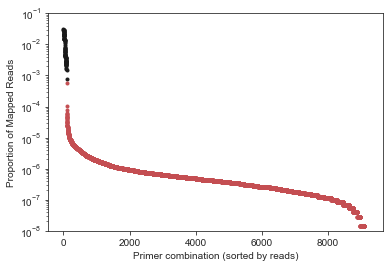

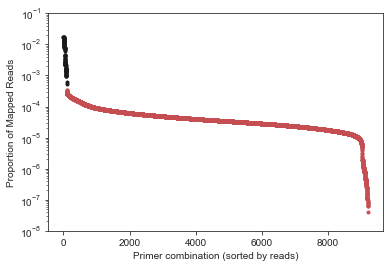

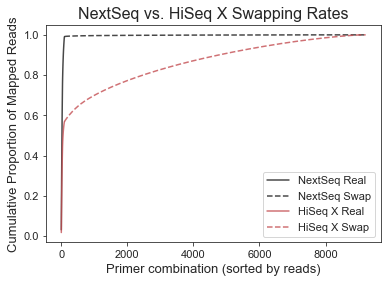

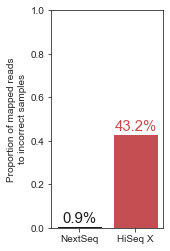

In [42]:
n_real = 95

totals = NS_totals
sorted_totals = list(totals.sort_values('total',ascending=False)['total'].values)

plt.plot(range(len(sorted_totals))[:n_real],sorted_totals[:n_real]/np.sum(sorted_totals),'k.')
plt.plot(range(len(sorted_totals))[n_real:],sorted_totals[n_real:]/np.sum(sorted_totals),'r.')
plt.yscale('log')
# plt.xscale('log')
# plt.axvline(96,color='k',linestyle='--',alpha=0.9)
plt.xlabel('Primer combination (sorted by reads)')
plt.ylabel('Proportion of Mapped Reads')
plt.ylim(10**-8,10**-1)

totals = HS_totals
sorted_totals = list(totals.sort_values('total',ascending=False)['total'].values)

plt.figure()
plt.plot(range(len(sorted_totals))[:n_real],sorted_totals[:n_real]/np.sum(sorted_totals),'k.')
plt.plot(range(len(sorted_totals))[n_real:],sorted_totals[n_real:]/np.sum(sorted_totals),'r.')
plt.yscale('log')
# plt.xscale('log')
# plt.axvline(96,color='k',linestyle='--',alpha=0.9)
plt.xlabel('Primer combination (sorted by reads)')
plt.ylabel('Proportion of Mapped Reads')
plt.ylim(10**-8,10**-1)

plt.figure()

totals = NS_totals
sorted_totals = list(totals.sort_values('total',ascending=False)['total'].values)
sorted_totals = np.cumsum(sorted_totals)

# plt.plot(range(len(sorted_totals))[:n_real],sorted_totals[:n_real]/np.sum(sorted_totals),'k',alpha=0.8)
# plt.plot(range(len(sorted_totals))[n_real:],sorted_totals[n_real:]/np.sum(sorted_totals),'k--',alpha=0.8)
plt.plot(range(len(sorted_totals))[:n_real],sorted_totals[:n_real]/(sorted_totals[-1]),'k',alpha=0.8)
plt.plot(range(len(sorted_totals))[n_real:],sorted_totals[n_real:]/(sorted_totals[-1]),'k--',alpha=0.8)
# plt.yscale('log')
# plt.xscale('log')
# plt.axvline(96,color='k',linestyle='--',alpha=0.9)
plt.xlabel('Primer combination (sorted by reads)',fontsize=12)
plt.ylabel('Proportion of Mapped Reads',fontsize=12)
# plt.ylim(10**-8,10**-1)

totals = HS_totals
sorted_totals = list(totals.sort_values('total',ascending=False)['total'].values)
sorted_totals = np.cumsum(sorted_totals)

# plt.figure()
# plt.plot(range(len(sorted_totals))[:n_real],sorted_totals[:n_real]/np.sum(sorted_totals),'r',alpha=0.8)
# plt.plot(range(len(sorted_totals))[n_real:],sorted_totals[n_real:]/np.sum(sorted_totals),'r--',alpha=0.8)
plt.plot(range(len(sorted_totals))[:n_real],sorted_totals[:n_real]/(sorted_totals[-1]),'r',alpha=0.8)
plt.plot(range(len(sorted_totals))[n_real:],sorted_totals[n_real:]/(sorted_totals[-1]),'r--',alpha=0.8)
# plt.yscale('log')
# plt.xscale('log')
# plt.axvline(96,color='k',linestyle='--',alpha=0.9)

plt.xlabel('Primer combination (sorted by reads)',fontsize=13)
plt.ylabel('Cumulative Proportion of Mapped Reads',fontsize=13)
# plt.ylim(10**-8,10**-1)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(['NextSeq Real','NextSeq Swap','HiSeq X Real','HiSeq X Swap'],fontsize=11)
plt.title('NextSeq vs. HiSeq X Swapping Rates',fontsize=16)
plt.savefig('swapplot_hi_v_next_both_cumsum.pdf',bbox_inches='tight')
plt.savefig('swapplot_hi_v_next_both_cumsum_500.png',bbox_inches='tight',dpi=500)

plt.figure(figsize=(2,4))

totals = NS_totals
sorted_totals = list(totals.sort_values('total',ascending=False)['total'].values)
# sorted_totals = np.cumsum(sorted_totals)

plt.bar([0],[1-sum(sorted_totals[:n_real])/np.sum(sorted_totals)],color='k')

plt.text(0,1-sum(sorted_totals[:n_real])/np.sum(sorted_totals),
         f'{1-sum(sorted_totals[:n_real])/np.sum(sorted_totals):.1%}',
        fontsize=15,ha='center',color='k',va='bottom')

totals = HS_totals
sorted_totals = list(totals.sort_values('total',ascending=False)['total'].values)
# sorted_totals = np.cumsum(sorted_totals)

plt.bar([1],[1-sum(sorted_totals[:n_real])/np.sum(sorted_totals)],color='r')

plt.text(1,1-sum(sorted_totals[:n_real])/np.sum(sorted_totals),
         f'{1-sum(sorted_totals[:n_real])/np.sum(sorted_totals):.1%}',
        fontsize=15,ha='center',color='r',va='bottom')


plt.yticks()
plt.xticks([0,1],['NextSeq','HiSeq X'])
plt.ylabel('Proportion of mapped reads\nto incorrect samples')
plt.ylim(0,1)

plt.savefig('swapplot_hi_v_next_botutth_bar.pdf',bbox_inches='tight')

# plt.figure()
# plt.plot(range(len(sorted_totals))[:96],sorted_totals[:96],'k.')
# plt.plot(range(len(sorted_totals))[96:],sorted_totals[96:],'r.')
# plt.yscale('log')

# # plt.axvline(96,color='k',linestyle='--',alpha=0.9)
# plt.xlabel('Primer combination (sorted by reads)')
# plt.ylabel('Total Mapped Reads')
# plt.xlim(-5,110)
# plt.ylim(5*10**3,5*10**6)

In [39]:
sorted_totals/sorted_totals[-1]

array([4.12591333e+05, 4.11005833e+05, 4.07190333e+05, ...,
       1.50000000e+00, 1.50000000e+00, 1.00000000e+00])

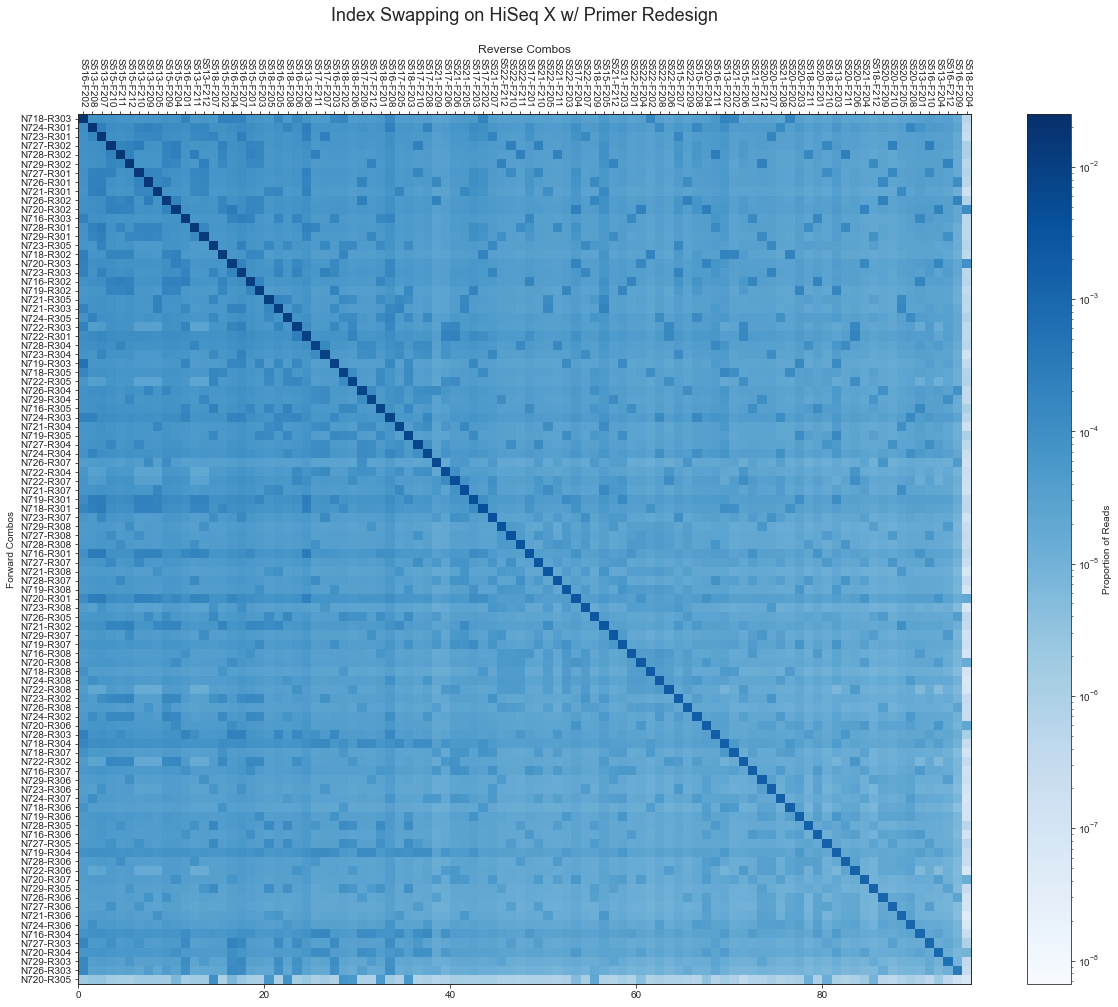

In [26]:
# Grid of all possible primer combinations
totals = HS_totals
fwd_combo_list = []
rev_combo_list = []
for item in range(len(totals)):
    fwd_combo_list.append(totals['N'].values[item] + '-' + totals['R'].values[item])
    rev_combo_list.append(totals['S'].values[item] + '-' + totals['F'].values[item])
totals['fwd_combo'] = fwd_combo_list
totals['rev_combo'] = rev_combo_list
totals = totals.sort_values(['total'],ascending=False)
total_fwds, ix = np.unique(totals['fwd_combo'].values,return_index=True)
total_fwds = total_fwds[np.argsort(ix)]
total_revs, ix  = np.unique(totals['rev_combo'].values,return_index=True)
total_revs = total_revs[np.argsort(ix)]
fwdSorter = dict(zip(total_fwds,range(len(total_fwds))))
revSorter = dict(zip(total_revs,range(len(total_revs))))
totals['fwd_rank'] = totals['fwd_combo'].map(fwdSorter)
totals['rev_rank'] = totals['rev_combo'].map(revSorter)
totals =  totals.sort_values(['fwd_rank','rev_rank'])

n_primers = np.unique(totals['N'].values)
s_primers = np.unique(totals['S'].values)
f_primers = np.unique(totals['F'].values)
r_primers = np.unique(totals['R'].values)

fwd_combos = total_fwds
rev_combos = total_revs
# all

# nextera_totals.sort_values(['fwd_rank','rev_rank'],ascending=[True,True])


all_counts = totals['total'].values

# true_pairs = copy.copy(all_counts)
# for i in range(len(all_counts)):
#     if totals['real_read'].values[i] == True:
#         all_counts[i] = 0
#         true_pairs[i] = 1.0
#     else:
#         true_pairs[i] = 0.0
    
# print(all_)
all_counts = all_counts.reshape(len(n_primers)*len(r_primers),len(s_primers)*len(f_primers))
# true_pairs = true_pairs.reshape(len(n_primers)*len(r_primers),len(s_primers)*len(f_primers))
    
    
fig, ax1 = plt.subplots(figsize=(20,16))
# pcm = plt.pcolormesh(master_list,cmap='Blues')
# pcm = plt.pcolormesh(all_counts/np.sum(all_counts),cmap='Blues',norm=colors.LogNorm(np.min(1/np.sum(all_counts)),np.max(all_counts/np.sum(all_counts))))
pcm = plt.pcolormesh(all_counts/np.sum(all_counts),cmap='Blues',
                     norm=colors.LogNorm(np.min(1/150000000),np.max(0.025)))

cbar = fig.colorbar(pcm,pad=0.05)
cbar.set_label('Proportion of Reads')

# plt.title('Index Swapping BB 082818 HiSeq X Nextera',y=1.15,fontsize=13)
plt.title('Index Swapping on HiSeq X w/ Primer Redesign',y=1.1,fontsize=18)

# plt.plot(np.asarray(range(8))+0.5,np.asarray(range(8))+0.5,'ro',linestyle='')
plt.gca().invert_yaxis()
ax1.xaxis.tick_top()

# #     plt.xlabel('Percentage of Reads to Correct Rev. Primer',fontsize=11)
# #     plt.xticks(np.asarray(range(len(f_primers)))+0.5,[str(round(max(i)/sum(i)*100,0)).split('.')[0] + '%' for i in np.asarray(master_list).swapaxes(0,1)])
plt.ylabel('Forward Combos',fontsize=10)
plt.yticks(np.asarray(range(len(fwd_combos)))+0.5,fwd_combos)

# ax2 = ax1.twinx()
# ax2.set_ylim(ax1.get_ylim())
# #     ax2.set_ylabel('Percentage of Reads to Correct Fwd. Primer',fontsize=11)
# #     ax2.set_yticks(np.asarray(range(len(master_list)))+0.5)
# #     ax2.set_yticklabels([str(round(max(i)/sum(i)*100,0)).split('.')[0] + '%' for i in master_list])

ax3 = ax1.twiny()
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(np.asarray(range(len(rev_combos)))+0.5,minor=False)
ax3.set_xticklabels(rev_combos,rotation=270)
ax3.set_xlabel('Reverse Combos',fontsize=12)
#     leg = fig.legend(['True Pairs'],loc=(0.72,0.04),handletextpad=0.005,fontsize=11)
#     for text in leg.get_texts():
#         text.set_color('r')
plt.savefig('bb_082818_hiseqX_combos_biggrid_proportion.pdf',bbox_inches='tight')
plt.savefig('bb_082818_hiseqX_combos_biggrid_proportion_500.png',bbox_inches='tight',dpi=500)
# plt.savefig('bb_080618_nextseq_combos.pdf',bbox_inches='tight')

In [27]:
np.sum(all_counts)

144132274

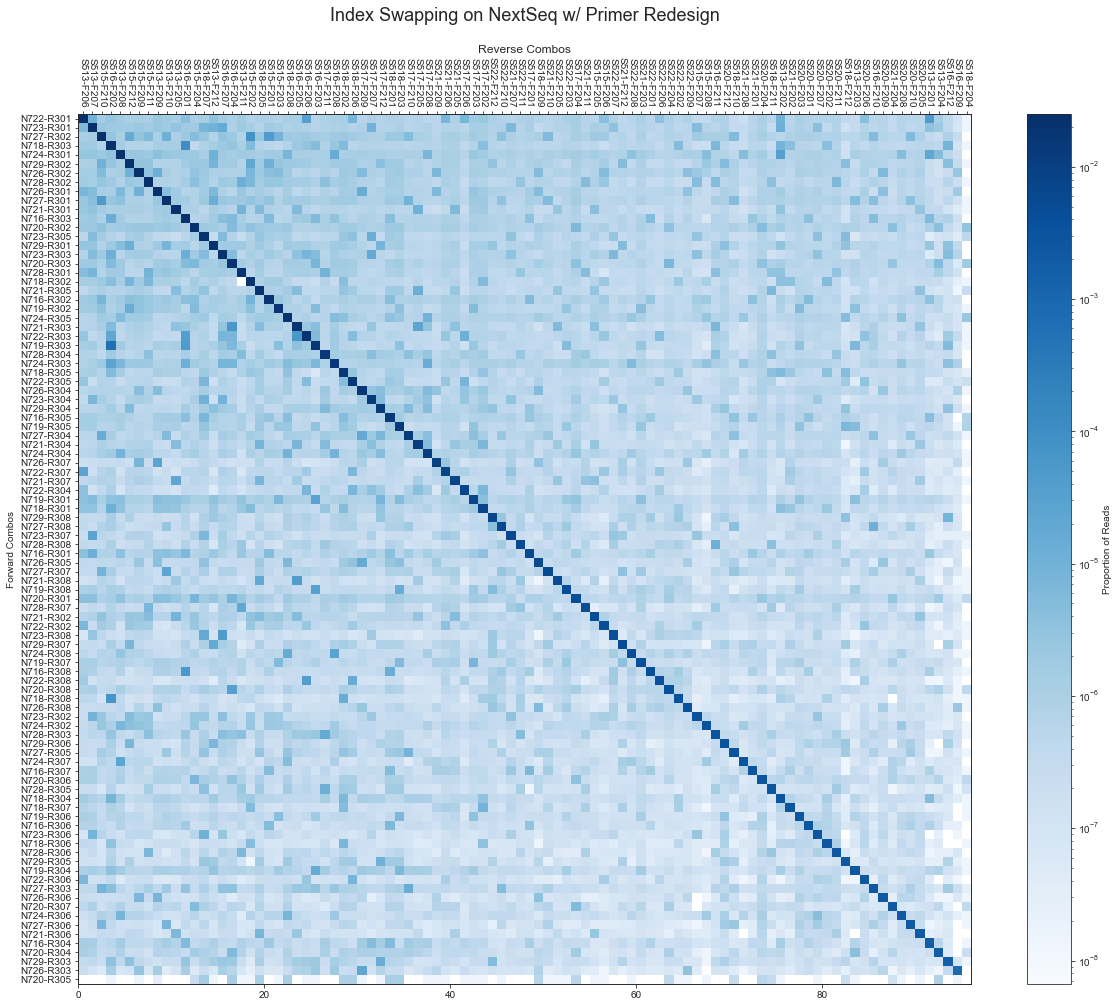

In [28]:
# Grid of all possible primer combinations
totals = NS_totals
fwd_combo_list = []
rev_combo_list = []
for item in range(len(totals)):
    fwd_combo_list.append(totals['N'].values[item] + '-' + totals['R'].values[item])
    rev_combo_list.append(totals['S'].values[item] + '-' + totals['F'].values[item])
totals['fwd_combo'] = fwd_combo_list
totals['rev_combo'] = rev_combo_list
totals = totals.sort_values(['total'],ascending=False)
total_fwds, ix = np.unique(totals['fwd_combo'].values,return_index=True)
total_fwds = total_fwds[np.argsort(ix)]
total_revs, ix  = np.unique(totals['rev_combo'].values,return_index=True)
total_revs = total_revs[np.argsort(ix)]
fwdSorter = dict(zip(total_fwds,range(len(total_fwds))))
revSorter = dict(zip(total_revs,range(len(total_revs))))
totals['fwd_rank'] = totals['fwd_combo'].map(fwdSorter)
totals['rev_rank'] = totals['rev_combo'].map(revSorter)
totals =  totals.sort_values(['fwd_rank','rev_rank'])

n_primers = np.unique(totals['N'].values)
s_primers = np.unique(totals['S'].values)
f_primers = np.unique(totals['F'].values)
r_primers = np.unique(totals['R'].values)

fwd_combos = total_fwds
rev_combos = total_revs
# all

# nextera_totals.sort_values(['fwd_rank','rev_rank'],ascending=[True,True])


all_counts = totals['total'].values

# true_pairs = copy.copy(all_counts)
# for i in range(len(all_counts)):
#     if totals['real_read'].values[i] == True:
#         all_counts[i] = 0
#         true_pairs[i] = 1.0
#     else:
#         true_pairs[i] = 0.0
    
# print(all_)
all_counts = all_counts.reshape(len(n_primers)*len(r_primers),len(s_primers)*len(f_primers))
# true_pairs = true_pairs.reshape(len(n_primers)*len(r_primers),len(s_primers)*len(f_primers))
    
    
fig, ax1 = plt.subplots(figsize=(20,16))
# pcm = plt.pcolormesh(master_list,cmap='Blues')
# pcm = plt.pcolormesh(all_counts/np.sum(all_counts),cmap='Blues',
#                      norm=colors.LogNorm(np.min(1/np.sum(all_counts)),np.max(all_counts/np.sum(all_counts))))
pcm = plt.pcolormesh(all_counts/np.sum(all_counts),cmap='Blues',
                     norm=colors.LogNorm(np.min(1/150000000),np.max(0.025)))
cbar = fig.colorbar(pcm,pad=0.05)
cbar.set_label('Proportion of Reads')

# plt.title('Index Swapping BB 082818 HiSeq X Nextera',y=1.15,fontsize=13)
plt.title('Index Swapping on NextSeq w/ Primer Redesign',y=1.1,fontsize=18)

# plt.plot(np.asarray(range(8))+0.5,np.asarray(range(8))+0.5,'ro',linestyle='')
plt.gca().invert_yaxis()
ax1.xaxis.tick_top()

# #     plt.xlabel('Percentage of Reads to Correct Rev. Primer',fontsize=11)
# #     plt.xticks(np.asarray(range(len(f_primers)))+0.5,[str(round(max(i)/sum(i)*100,0)).split('.')[0] + '%' for i in np.asarray(master_list).swapaxes(0,1)])
plt.ylabel('Forward Combos',fontsize=10)
plt.yticks(np.asarray(range(len(fwd_combos)))+0.5,fwd_combos)

# ax2 = ax1.twinx()
# ax2.set_ylim(ax1.get_ylim())
# #     ax2.set_ylabel('Percentage of Reads to Correct Fwd. Primer',fontsize=11)
# #     ax2.set_yticks(np.asarray(range(len(master_list)))+0.5)
# #     ax2.set_yticklabels([str(round(max(i)/sum(i)*100,0)).split('.')[0] + '%' for i in master_list])

ax3 = ax1.twiny()
ax3.set_xlim(ax1.get_xlim())
ax3.set_xticks(np.asarray(range(len(rev_combos)))+0.5,minor=False)
ax3.set_xticklabels(rev_combos,rotation=270)
ax3.set_xlabel('Reverse Combos',fontsize=12)
#     leg = fig.legend(['True Pairs'],loc=(0.72,0.04),handletextpad=0.005,fontsize=11)
#     for text in leg.get_texts():
#         text.set_color('r')
# plt.savefig('bb_082818_hiseqX_combos.pdf',bbox_inches='tight')
plt.savefig('bb_080618_nextseq_combos_biggrid_proportion.pdf',bbox_inches='tight')
plt.savefig('bb_080618_nextseq_combos_biggrid_proportion_500.png',bbox_inches='tight',dpi=500)
# plt.savefig('bb_080618_nextseq_combos.pdf',bbox_inches='tight')

In [29]:
np.sum(all_counts)

71986544

In [30]:
144132274/71986544

2.002211329939662

In [31]:
full_neutral_list = [17615,18486,42040,45014,58284,63611,73731,74185,80465,94896
,120600,125697,132511,134852,135750,190551,228237,238783,255561,298344
,308537,316954,317346,335717,411685,454359,469053] 

### from previous list but never has fitness above 3.5% (per gen) in any of 5000bc experiments
supergood_neutral = [17615, 24362, 42040, 71926, 72939, 73802, 80465, 109476, 113483, 
                     134852, 135750, 238783, 263665, 276406, 316954, 335717, 454359] 

### pulled from supergood list and spiked into 1BigBatch experiments
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,263665,316954]
neutral_spikes = [17615,24362,42040,71926,73802,109476,113483,134852,316954]

neutrals = list(np.unique(full_neutral_list+supergood_neutral+neutral_spikes))

gpb2s = [  2288,   2768,   7774,   7799,   9888,  10851,  11933,  14280,
        17691,  19407,  23688,  33617,  63215, 121806]
ira1_nons = [9000101,9000104,9000105,9000106,9000107,9000109,9000110]
ira1_nons = [151,273,415,689,6174,7836,9864,10794,11752,13132,15232,18420,21967,23868,25531,28740,30578,31360,40409,43483,57117]

## SECOND PASS
# neutrals = fitness_df[fitness_df['mutation_type'].isin(['ExpNeutral','other'])]['barcode'].values

# neutrals = [bc for bc in dataset['BCID'].values if bc in neutrals]



NameError: name 'dataset' is not defined

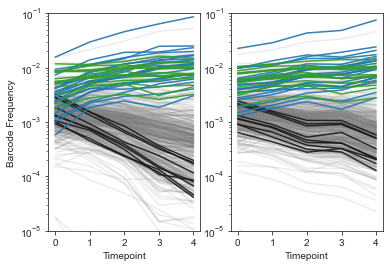

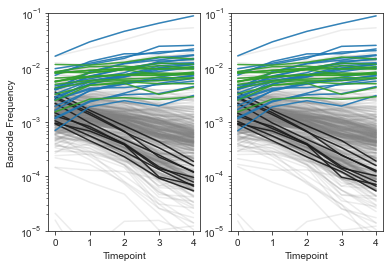

In [47]:
timepoints = {'A0':'N716_S513_F201_R304',
              'A1':'N718_S515_F202_R302',
              'A2':'N723_S517_F207_R304',
#               'A3':'N729_S518_F209_R305',
              'A4':'N721_S521_F205_R307'}

timepoints = {'BB0':'N727_S513_F210_R301',
              'BB1':'N723_S516_F207_R303',
              'BB2':'N724_S518_F208_R305',
              'BB3':'N716_S521_F201_R307',
              'BB4':'N722_S522_F206_R308'}

timepoints = {'D0':'N718_S513_F202_R304',
              'D1':'N719_S515_F203_R302',
              'D2':'N724_S517_F208_R304',
              'D3':'N716_S520_F201_R306',
              'D4':'N722_S521_F206_R307'}

datasets = [bb_082818_HS,bb_080618_NS]
dataset_names = ['HiSeqX','NextSeq']

f_list = ['F' + str(f) for f in range(201,213)] # inline forward primers
r_list = ['R' + str(r) for r in range(301,309)] # inline reverse primers 



for d,dataset in enumerate(datasets):
    
    dataset = dataset[dataset['BCID']!=7777777]
    dataset = dataset.sort_values('BCID')
    
    neutral_locs = np.where(dataset['BCID'].isin(neutral_spikes))[0]
    gpb2_locs = np.where(dataset['BCID'].isin(gpb2s))[0]
    ira1_locs = np.where(dataset['BCID'].isin(ira1_nons))[0]
    
    times = np.asarray([int(k[-1]) for k in timepoints.keys()])
    freqs = dataset[[v for v in timepoints.values()]].values/np.nansum(dataset[[v for v in timepoints.values()]].values,axis=0)
    plt.figure(figsize=(6,4))
    ax1 = plt.subplot(1,2,1)
#     plt.title('Nested Unique Dual Indexing')
    plt.plot(times,freqs.swapaxes(0,1)[:,:],alpha=0.15,color='gray')
    plt.plot(times,freqs.swapaxes(0,1)[:,neutral_locs],alpha=0.9,color='k')
    plt.plot(times,freqs.swapaxes(0,1)[:,ira1_locs],alpha=0.9,color='#1f78b4')
    plt.plot(times,freqs.swapaxes(0,1)[:,gpb2_locs],alpha=0.9,color='#33a02c')
    plt.xticks(times,times)
    plt.yscale('log')
    plt.ylim(10**-5,0.1)
    plt.ylabel('Barcode Frequency')
    plt.xlabel('Timepoint')
    
    counts = np.zeros(dataset[[v for v in timepoints.values()]].values.shape)
#     times = np.asarray([int(k[-1]) for k in timepoints.keys()])
    for i,(key,index) in enumerate(timepoints.items()):
        realN,realS,realF,realR = index.split('_')
        for f in f_list:
            for r in r_list:
                counts[:,i] = counts[:,i] + dataset[f'{realN}_{realS}_{f}_{r}'].values
                
    freqs = counts/np.nansum(counts,axis=0)
    plt.subplot(1,2,2,sharey=ax1)
#     plt.title('Combinatorial Indexing')
    plt.plot(times,freqs.swapaxes(0,1)[:,:],alpha=0.15,color='gray')
    plt.plot(times,freqs.swapaxes(0,1)[:,neutral_locs],alpha=0.9,color='k')
    plt.plot(times,freqs.swapaxes(0,1)[:,ira1_locs],alpha=0.9,color='#1f78b4')
    plt.plot(times,freqs.swapaxes(0,1)[:,gpb2_locs],alpha=0.9,color='#33a02c')
    plt.xticks(times,times)
    plt.yscale('log')
    plt.ylim(10**-5,0.1)
    plt.yticks()
#     plt.ylabel('Barcode Frequency')
    plt.xlabel('Timepoint')
    
    plt.savefig(f'example_trajectory_from_hopping_{dataset_names[d]}_D.pdf',bbox_inches='tight')


In [50]:
import sys
import os
atish_assay_path = 'code/fitness_assay_grantedits.py'
sys.path.append(os.path.dirname(os.path.expanduser(atish_assay_path)))
import fitness_assay_grantedits as atish

tools_path = 'code/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [51]:
fitnesses = {}


for d,dataset in enumerate(datasets):
    dataset = dataset[dataset['BCID']!=7777777]
    dataset = dataset.sort_values('BCID')
    
    
    
    fitnesses[dataset_names[d]] = {}
    
    times = np.asarray([int(k[-1]) for k in timepoints.keys()])
    
    real_counts = dataset[[v for v in timepoints.values()]].values
    answer = atish.inferFitness(dataset['BCID'].values,times,{1:real_counts},
                                neutralBarcodes=neutrals,lowCoverageThresh=10**5,use_all_neutral=False,useMultNoise=True,weightedMean=True)

    fitnesses[dataset_names[d]]['real'] = answer[1]['aveFitness']
    
    counts = np.zeros(dataset[[v for v in timepoints.values()]].values.shape)
#     times = np.asarray([int(k[-1]) for k in timepoints.keys()])
    for i,(key,index) in enumerate(timepoints.items()):
        realN,realS,realF,realR = index.split('_')
        for f in f_list:
            for r in r_list:
                counts[:,i] = counts[:,i] + dataset[f'{realN}_{realS}_{f}_{r}'].values
                
    answer = atish.inferFitness(dataset['BCID'].values,times,{1:counts},
                                neutralBarcodes=neutrals,lowCoverageThresh=10**5,use_all_neutral=False,useMultNoise=True,weightedMean=True)
    
    fitnesses[dataset_names[d]]['swapped'] = answer[1]['aveFitness']

neutrals inside 1
5
neutral reads True 289.0 1233.0
neutral reads True 1233.0 358.0
neutral reads True 358.0 31.0
neutral reads True 31.0 44.0
neutral reads False 289.0 1233.0
neutral reads False 1233.0 358.0
neutral reads False 358.0 31.0
neutral reads False 31.0 44.0
Multiplicative noise consistency checks

1  inconsistent times:

kappas [0. 0. 0. 0.]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

neutrals inside 1
5
neutral reads True 1265.0 2039.0
neutral reads True 2039.0 754.0
neutral reads True 754.0 257.0
neutral reads True 257.0 239.0
neutral reads False 1265.0 2039.0
neutral reads False 2039.0 754.0
neutral reads False 754.0 257.0
neutral reads False 257.0 239.0
Multiplicative noise consistency checks

1  inconsistent times:

kappas [0. 0. 0. 0.]
multNoise [0.1 0.1 0.1 0.1]
No clear inconsistencies

neutrals inside 1
5
neutral reads True 247.0 1103.0
neutral reads True 1103.0 311.0
neutral reads True 311.0 27.0
neutral reads True 27.0 55.0
neutral reads False 247.0 110

/Users/grantkinsler/Documents/Stanford/Research/BarcodersGuide/code/fitness_assay_grantedits.py:235: RuntimeWarning: divide by zero encountered in power
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/BarcodersGuide/code/fitness_assay_grantedits.py:235: RuntimeWarning: invalid value encountered in multiply
  zScores = zScores*np.power(expectedReads,-0.5)
/Users/grantkinsler/Documents/Stanford/Research/BarcodersGuide/code/fitness_assay_grantedits.py:406: RuntimeWarning: divide by zero encountered in log
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/BarcodersGuide/code/fitness_assay_grantedits.py:406: RuntimeWarning: invalid value encountered in subtract
  allTimeFitness = np.log(allReads[repName][:,1:]/totReads[1:])-np.log(allReads[repName][:,0:-1]/totReads[0:-1])
/Users/grantkinsler/Documents/Stanford/Research/BarcodersGuide

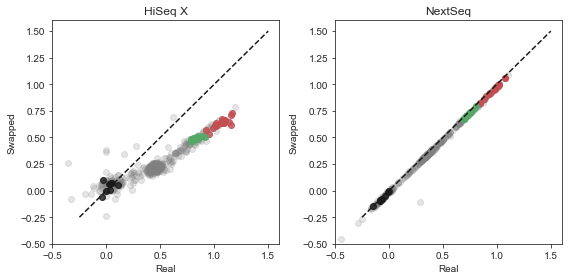

In [52]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title('HiSeq X')
plt.scatter(fitnesses['HiSeqX']['real'],fitnesses['HiSeqX']['swapped'],alpha=0.2,color='gray')
plt.scatter(fitnesses['HiSeqX']['real'][ira1_locs],fitnesses['HiSeqX']['swapped'][ira1_locs],alpha=0.8,color='r')
plt.scatter(fitnesses['HiSeqX']['real'][gpb2_locs],fitnesses['HiSeqX']['swapped'][gpb2_locs],alpha=0.8,color='g')
plt.scatter(fitnesses['HiSeqX']['real'][neutral_locs],fitnesses['HiSeqX']['swapped'][neutral_locs],alpha=0.8,color='k')
plt.plot([-0.25,1.5],[-0.25,1.5],'k--')
plt.xlim(-0.5,1.6)
plt.ylim(-0.5,1.6)
plt.xlabel('Real')
plt.ylabel('Swapped')

# plt.figure()
plt.subplot(1,2,2)
plt.title('NextSeq')
plt.scatter(fitnesses['NextSeq']['real'],fitnesses['NextSeq']['swapped'],alpha=0.2,color='gray')
plt.scatter(fitnesses['NextSeq']['real'][ira1_locs],fitnesses['NextSeq']['swapped'][ira1_locs],alpha=0.8,color='r')
plt.scatter(fitnesses['NextSeq']['real'][gpb2_locs],fitnesses['NextSeq']['swapped'][gpb2_locs],alpha=0.8,color='g')
plt.scatter(fitnesses['NextSeq']['real'][neutral_locs],fitnesses['NextSeq']['swapped'][neutral_locs],alpha=0.8,color='k')
plt.plot([-0.25,1.5],[-0.25,1.5],'k--')
plt.xlim(-0.5,1.6)
plt.ylim(-0.5,1.6)
plt.xlabel('Real')
plt.ylabel('Swapped')

plt.tight_layout()

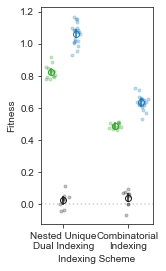

In [53]:

plt.figure(figsize=(2,4))
plt.scatter([tools.jitter_point(-0.1,0.02) for x in gpb2_locs],fitnesses['HiSeqX']['real'][gpb2_locs],marker='.',color='#33a02c',alpha=0.25)

plt.scatter([tools.jitter_point(0.1,0.02) for x in ira1_locs],fitnesses['HiSeqX']['real'][ira1_locs],marker='.',color='#1f78b4',alpha=0.25)
plt.scatter([tools.jitter_point(0,0.02) for x in neutral_locs],fitnesses['HiSeqX']['real'][neutral_locs],marker='.',color='k',alpha=0.25)

plt.errorbar(-0.1,np.mean(fitnesses['HiSeqX']['real'][gpb2_locs]),
             yerr=1.96*np.std(fitnesses['HiSeqX']['real'][gpb2_locs])/np.sqrt(len(gpb2_locs))
             ,marker='o',markerfacecolor='none',color='#33a02c')
plt.errorbar(0.1,np.mean(fitnesses['HiSeqX']['real'][ira1_locs]),
             yerr=1.96*np.std(fitnesses['HiSeqX']['real'][ira1_locs])/np.sqrt(len(ira1_locs))
             ,marker='o',markerfacecolor='none',color='#1f78b4')
plt.errorbar(0.0,np.mean(fitnesses['HiSeqX']['real'][neutral_locs]),
             yerr=1.96*np.std(fitnesses['HiSeqX']['real'][neutral_locs])/np.sqrt(len(neutral_locs))
             ,marker='o',markerfacecolor='none',color='k')


plt.scatter([tools.jitter_point(0.5-0.1,0.02) for x in gpb2_locs],fitnesses['HiSeqX']['swapped'][gpb2_locs],marker='.',alpha=0.25,color='#33a02c')
plt.scatter([tools.jitter_point(0.5+0.1,0.02) for x in ira1_locs],fitnesses['HiSeqX']['swapped'][ira1_locs],marker='.',alpha=0.25,color='#1f78b4')
plt.scatter([tools.jitter_point(0.5+0,0.02) for x in neutral_locs],fitnesses['HiSeqX']['swapped'][neutral_locs],marker='.',alpha=0.25,color='k')

plt.errorbar(0.5-0.1,np.mean(fitnesses['HiSeqX']['swapped'][gpb2_locs]),
             yerr=1.96*np.std(fitnesses['HiSeqX']['real'][gpb2_locs])/np.sqrt(len(gpb2_locs))
             ,marker='o',markerfacecolor='none',color='#33a02c')
plt.errorbar(0.5+0.1,np.mean(fitnesses['HiSeqX']['swapped'][ira1_locs]),
             yerr=1.96*np.std(fitnesses['HiSeqX']['real'][ira1_locs])/np.sqrt(len(ira1_locs))
             ,marker='o',markerfacecolor='none',color='#1f78b4')
plt.errorbar(0.5,np.mean(fitnesses['HiSeqX']['swapped'][neutral_locs]),
             yerr=1.96*np.std(fitnesses['HiSeqX']['real'][neutral_locs])/np.sqrt(len(neutral_locs))
             ,marker='o',markerfacecolor='none',color='k')

plt.xticks([0,0.5],['Nested Unique\nDual Indexing','Combinatorial\nIndexing'])
plt.ylabel('Fitness')
plt.xlabel('Indexing Scheme')

plt.axhline(0,color='k',linestyle=':',alpha=0.2)
# plt.axhline(0,color='k',linestyle=':',alpha=0.2)

plt.savefig('index_swapping_fitness_consequence_D.pdf',bbox_inches='tight')

In [54]:
dataset[[v for v in timepoints.values()]].values

array([[  329,  1895,   889,   166,   320],
       [ 3111, 39859, 37562, 12722, 51453],
       [  269,  1400,   688,   106,   260],
       ...,
       [    0,     0,     0,     0,     0],
       [   51,   850,   518,   104,   364],
       [  373,  4410,  2535,   657,  2336]])

In [93]:
paper_data = p.read_csv('../1BigBatchPaper/data/Kinsler_et_al_2020_fitnessdata.csv')

In [132]:
paper_data[paper_data['barcode'].isin(neutral_spikes)][['barcode','D_fitness']]

,barcode,D_fitness
114,17615,-0.032916
161,24362,0.006511
211,42040,-0.027473
288,71926,-0.027571
293,73802,-0.035949
340,109476,-0.001194
346,113483,-0.068544
370,134852,-0.029467
459,263665,-0.161007
482,316954,-0.048923


In [115]:
len(gpb2_locs)

14

In [116]:
dataset

,BCID,N726_S518_F212_R303,N728_S517_F204_R306,N716_S521_F209_R304,N716_S513_F212_R302,N726_S516_F201_R303,N720_S522_F211_R302,N727_S515_F203_R303,N728_S522_F206_R301,N721_S522_F210_R306,...,N729_S521_F205_R307,N721_S518_F209_R301,N716_S516_F211_R306,N726_S517_F209_R308,N724_S521_F211_R303,N728_S518_F203_R302,N722_S513_F207_R304,N729_S513_F205_R302,N727_S515_F210_R303,N729_S520_F203_R305
0,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0
1,151,0,0,0,2,3,1,0,2,0,...,2,0,0,9,1,2,0,2,18,0
2,262,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,273,0,0,1,0,1,1,1,1,0,...,1,0,0,2,0,1,0,0,9,0
4,323,0,0,0,1,0,0,1,0,0,...,0,0,0,2,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,9000107,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
545,9000108,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
546,9000109,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
547,9000110,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
